In [15]:
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
import os

In [16]:
class FFTLowFreqSelector(torch.nn.Module):
    """
    MNIST/FashionMNIST 等の2D画像を FFT し、fftshift 後の中心(低周波)から
    周波数成分を抜き出して特徴ベクトルにするクラス。

    - 入力: x (B, C, H, W)  [float]
    - 出力: (B, out_dim)    [float]
    """
    def __init__(self, out_dim: int = 32, mode: str = 'magnitude', 
                 freq_select: str = 'low', log_magnitude: bool = True, eps: float = 1e-12):
        super().__init__()
        self.out_dim = int(out_dim)
        self.mode = mode  # 'magnitude' or 'phase'
        self.freq_select = freq_select  # 'low' or 'high'
        self.log_magnitude = bool(log_magnitude)
        self.eps = float(eps)
        # 画像サイズごとに選択インデックスをキャッシュ
        self._cached_idx = {}   # key=(H,W,freq_select) -> dict{"flat": LongTensor(K,), "ij": LongTensor(K,2)}

    @torch.no_grad()
    def _prepare_indices(self, H: int, W: int, device: torch.device):
        """周波数選択方法に応じてインデックスを決定"""
        cache_key = (H, W, self.freq_select)
        if cache_key in self._cached_idx:
            return
        
        # 座標グリッド（行=Y=i, 列=X=j）
        ys = torch.arange(H, device=device).float()
        xs = torch.arange(W, device=device).float()
        yy, xx = torch.meshgrid(ys, xs, indexing="ij")

        cy = (H - 1) / 2.0
        cx = (W - 1) / 2.0
        dy = yy - cy
        dx = xx - cx
        r2 = dy * dy + dx * dx
        ang = torch.atan2(dy, dx)  # -pi..pi

        # (H*W,) にして複合キーでソート
        r2_f = r2.flatten()
        ang_f = ang.flatten()
        
        # 1) 角度でソートインデックス
        _, idx_ang = torch.sort(ang_f)
        # 2) 上の結果を使って距離でソート
        if self.freq_select == 'low':
            # 低周波（中心から近い順）
            r2_sorted, idx_r2 = torch.sort(r2_f[idx_ang], stable=True)
        elif self.freq_select == 'high':
            # 高周波（中心から遠い順）
            r2_sorted, idx_r2 = torch.sort(r2_f[idx_ang], stable=True, descending=True)
        else:
            raise ValueError(f"Invalid freq_select: {self.freq_select}")
        
        idx_all = idx_ang[idx_r2]

        K = min(self.out_dim, H * W)
        idx_k = idx_all[:K]  # (K,)

        # 2次元インデックス (i,j)
        iy = (idx_k // W).long()
        ix = (idx_k %  W).long()
        ij = torch.stack([iy, ix], dim=1).long()

        self._cached_idx[cache_key] = {"flat": idx_k.long(), "ij": ij.long()}

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (B, C, H, W)
        return: (B, out_dim)
        """
        B, C, H, W = x.shape
        if self.out_dim > H * W:
            raise ValueError(f"out_dim={self.out_dim} exceeds image size H*W={H*W}")

        self._prepare_indices(H, W, x.device)
        cache_key = (H, W, self.freq_select)
        idx_flat = self._cached_idx[cache_key]["flat"]  # (K,)
        
        # FFT -> shift
        X = torch.fft.fft2(x, dim=(-2, -1))
        X = torch.fft.fftshift(X, dim=(-2, -1))

        if self.mode == 'magnitude':
            # 振幅
            mag = X.abs()
            if self.log_magnitude:
                mag = torch.log1p(mag + self.eps)
            mag_flat = mag.reshape(B, C, H * W)
            feats = torch.index_select(mag_flat, dim=2, index=idx_flat).mean(dim=1)  # (B, K)
        elif self.mode == 'phase':
            # 位相
            phase = torch.angle(X)  # -π ~ π
            phase_flat = phase.reshape(B, C, H * W)
            feats = torch.index_select(phase_flat, dim=2, index=idx_flat).mean(dim=1)  # (B, K)
        else:
            raise ValueError(f"Invalid mode: {self.mode}")

        return feats

    @torch.no_grad()
    def get_selected_coords(self, H: int, W: int, device=None) -> torch.Tensor:
        """選ばれる (i,j) インデックス（K,2）を返す。"""
        dev = device if device is not None else torch.device("cpu")
        self._prepare_indices(H, W, dev)
        cache_key = (H, W, self.freq_select)
        return self._cached_idx[cache_key]["ij"].clone()

    @torch.no_grad()
    def reconstruct_from_lowfreq(self, x: torch.Tensor, sample_index: int = 0) -> torch.Tensor:
        """
        選択した低周波成分のみを使用して逆フーリエ変換で画像を復元する。
        - mode='magnitude': 振幅のみを使用（位相は0に固定）
        - mode='phase': 位相のみを使用（振幅は1に固定）
        
        Args:
            x: 入力画像テンソル (B, C, H, W)
            sample_index: 復元するサンプルのインデックス
            
        Returns:
            復元された画像 (H, W)
        """
        B, C, H, W = x.shape
        if not (0 <= sample_index < B):
            raise IndexError(f"sample_index {sample_index} out of range (0..{B-1})")
            
        self._prepare_indices(H, W, x.device)
        cache_key = (H, W, self.freq_select)
        idx_flat = self._cached_idx[cache_key]["flat"]  # (K,)
        ij = self._cached_idx[cache_key]["ij"]  # (K, 2)
        
        # 1サンプルのFFT
        x_single = x[sample_index:sample_index+1]  # (1, C, H, W)
        X = torch.fft.fft2(x_single, dim=(-2, -1))
        X_shifted = torch.fft.fftshift(X, dim=(-2, -1))
        
        # 低周波成分のみを保持するマスク作成
        X_lowfreq = torch.zeros_like(X_shifted)
        
        # 選択された低周波成分のみをコピー
        for c in range(C):
            for k in range(len(idx_flat)):
                i, j = ij[k]
                if self.mode == 'phase':
                    # 位相のみを使用: 振幅を1に固定
                    phase = torch.angle(X_shifted[0, c, i, j])
                    X_lowfreq[0, c, i, j] = torch.exp(1j * phase)
                elif self.mode == 'magnitude':
                    # 振幅のみを使用: 位相を0に固定（実数値）
                    magnitude = torch.abs(X_shifted[0, c, i, j])
                    X_lowfreq[0, c, i, j] = magnitude + 0j
                else:
                    raise ValueError(f"Invalid mode: {self.mode}")
        
        # 逆フーリエ変換
        X_lowfreq_ishifted = torch.fft.ifftshift(X_lowfreq, dim=(-2, -1))
        reconstructed = torch.fft.ifft2(X_lowfreq_ishifted, dim=(-2, -1)).real
        
        # チャンネル平均して (H, W) にする
        reconstructed = reconstructed.mean(dim=1).squeeze(0)  # (H, W)
        
        return reconstructed

    @torch.no_grad()
    def plot_example(self, x: torch.Tensor, sample_index: int = 0, annotate: bool = True, savepath: str = None):
        """
        バッチ x から sample_index 番目を可視化。
        ・元画像
        ・FFT(shift後)の log 振幅スペクトル
        ・どの out_dim 成分を抜いたか（スペクトル上にマーカー）
        ・低周波成分からの復元画像
        """
        B, C, H, W = x.shape
        if not (0 <= sample_index < B):
            raise IndexError(f"sample_index {sample_index} out of range (0..{B-1})")
        
        # 1枚取り出し（表示は1ch目）
        img_tensor = x[sample_index, 0].detach().cpu().float()  # (H, W)
        # 正規化を戻す: Normalize((0.5,), (0.5,)) の逆変換
        img = img_tensor * 0.5 + 0.5  # [-1,1] -> [0,1] に戻す
        img = torch.clamp(img, 0, 1)  # 範囲をクリップ
        img = img.numpy()

        # FFT計算
        X = torch.fft.fft2(x[sample_index:sample_index+1], dim=(-2, -1))
        X = torch.fft.fftshift(X, dim=(-2, -1))
        
        # モードに応じてスペクトル画像を切り替え
        if self.mode == 'phase':
            # 位相スペクトル (-π ~ π)
            phase = torch.angle(X).mean(dim=1)  # (1, H, W) チャンネル平均
            spec = phase[0].detach().cpu().float().numpy()
            spec_cmap = "twilight"  # 位相用カラーマップ
            spec_title = "FFT Phase"
        else:
            # 振幅スペクトル (log)
            mag = X.abs().mean(dim=1)  # (1, H, W) チャンネル平均
            spec = torch.log1p(mag + self.eps)[0].detach().cpu().float().numpy()
            spec_cmap = "gray"
            spec_title = "FFT Magnitude (log)"

        # 低周波成分からの復元画像
        reconstructed = self.reconstruct_from_lowfreq(x, sample_index)
        # 正規化を戻す
        reconstructed_denorm = reconstructed * 0.5 + 0.5
        reconstructed_denorm = torch.clamp(reconstructed_denorm, 0, 1)
        reconstructed_img = reconstructed_denorm.detach().cpu().numpy()

        # マーカー座標
        ij = self.get_selected_coords(H, W, device=x.device).cpu().numpy()  # (K,2)
        iy, ix = ij[:, 0], ij[:, 1]

        # 図を描く（4つのサブプロット）
        fig = plt.figure(figsize=(16, 4))
        ax1 = fig.add_subplot(1, 4, 1)
        ax2 = fig.add_subplot(1, 4, 2)
        ax3 = fig.add_subplot(1, 4, 3)
        ax4 = fig.add_subplot(1, 4, 4)

        ax1.imshow(img, cmap="gray", interpolation="nearest", vmin=0, vmax=1)
        ax1.set_title("Original")
        ax1.axis("off")

        ax2.imshow(spec, cmap=spec_cmap, interpolation="nearest")
        ax2.set_title(spec_title)
        ax2.axis("off")

        ax3.imshow(spec, cmap=spec_cmap, interpolation="nearest")
        # twilightカラーマップでは赤が見づらいので、黄緑(lime)や白(white)を使用
        marker_color = 'lime' if self.mode == 'phase' else 'red'
        text_color = 'black' if self.mode == 'phase' else 'blue'
        ax3.scatter(ix, iy, marker="o", s=30, c=marker_color, alpha=0.8, edgecolors='black', linewidths=0.5)
        if annotate:
            for k, (yy, xx) in enumerate(zip(iy, ix)):
                ax3.text(xx + 0.5, yy + 0.5, str(k+1), fontsize=7, color=text_color)
        ax3.set_title(f"Selected {self.out_dim} {self.freq_select}-freq bins ({self.mode})")
        ax3.axis("off")

        ax4.imshow(reconstructed_img, cmap="gray", interpolation="nearest", vmin=0, vmax=1)
        ax4.set_title("Reconstructed from low-freq")
        ax4.axis("off")

        plt.tight_layout()
        if savepath:
            plt.savefig(savepath, bbox_inches="tight", dpi=150)
        plt.show()

In [17]:
class PMEncoder(nn.Module):
    def __init__(self,input_dim,output_dim,alpha,device='cpu'):
        super(PMEncoder,self).__init__()
        phase = torch.rand(output_dim, input_dim) * 2 * np.pi - np.pi
        modulus = torch.ones(output_dim, input_dim)/np.sqrt(input_dim)

        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False
        self.alpha = (torch.rand(input_dim) - 0.5) * (2*alpha) 
        self.alpha = self.alpha.detach().to(device) 
        self.alpha.requires_grad = False

    def forward(self, x):
        x = torch.exp(1j * self.alpha * x) 
        x = x.T  
        x = torch.matmul(self.B, x).T 
        x = torch.abs(x)**2 
        return x

In [18]:
def load_Fmnist_data():
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),  # ±10度回転
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),  # 適切な正規化値
        lambda x: x.view(-1)
    ])

    root = os.path.join('..','..','dataloader', 'samples', 'Fmnist_data')
    fmnist_train = datasets.FashionMNIST(root=root,download=True,train=True,transform=transform)
    fmnist_test = datasets.FashionMNIST(root=root,download=True,train=False,transform=transform)
    return(fmnist_train,fmnist_test)

def get_new_dataloader(data_train,data_test,batch_size=100):
    train_dataloader = DataLoader(data_train,batch_size,shuffle=True)
    
    test_dataloader = DataLoader(data_test,batch_size,shuffle=False)
    return train_dataloader, test_dataloader

In [19]:
import csv
import os
import math
import torch
from tqdm import tqdm

def normalize_zero_one(x, eps=1e-8):
    # x を [0,1] に正規化
    eps = 1e-8
    xmin = x.min(dim=1, keepdim=True)[0]
    xmax = x.max(dim=1, keepdim=True)[0]
    x = (x - xmin) / (xmax - xmin + eps)
    return x

def save_fft_patterns_to_csv():
    """
    Fashion-MNISTデータをFFTLowFreqSelectorで4パターン変換し、それぞれCSVに保存する関数
    パターン: (magnitude/phase) × (low/high)
    """
    print("Loading Fashion-MNIST data...")
    
    # データ読み込み（シャッフルなし）
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    
    root = os.path.join('..','..','dataloader', 'samples', 'Fmnist_data')
    fmnist_train = datasets.FashionMNIST(root=root, download=True, train=True, transform=transform)
    
    # DataLoaderもシャッフルなしで作成
    train_dataloader = DataLoader(fmnist_train, batch_size=1000, shuffle=False)
    
    # 4パターンの設定
    patterns = [
        {'mode': 'magnitude', 'freq_select': 'low', 'filename': 'fft_magnitude_low.csv'},
        {'mode': 'magnitude', 'freq_select': 'high', 'filename': 'fft_magnitude_high.csv'},
        {'mode': 'phase', 'freq_select': 'low', 'filename': 'fft_phase_low.csv'},
        {'mode': 'phase', 'freq_select': 'high', 'filename': 'fft_phase_high.csv'},
    ]
    
    for pattern in patterns:
        mode = pattern['mode']
        freq_select = pattern['freq_select']
        csv_filename = pattern['filename']
        
        print(f"\n=== Processing: {mode} + {freq_select} ===")
        
        # FFTLowFreqSelectorの初期化
        extractor = FFTLowFreqSelector(out_dim=32, mode=mode, freq_select=freq_select, log_magnitude=True)
        
        print(f"Saving to {csv_filename}...")
        
        with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
            writer = csv.writer(csvfile)
            
            data_index = 0
            
            # バッチごとに処理
            for batch_idx, (x_batch, labels_batch) in enumerate(tqdm(train_dataloader, desc=f"{mode}_{freq_select}")):
                # 形状を調整 (batch_size, 1, 28, 28)
                x_batch = x_batch.view(x_batch.size(0), 1, 28, 28)
                
                # FFT変換
                fft_features = extractor(x_batch)  # (batch_size, 32)
                
                # 正規化処理
                if mode == 'phase':
                    # 位相の場合: 理論的な範囲 [-π, π] を [0, 1] に線形変換
                    # これにより、サンプルごとのばらつきに依存せず、絶対的な角度情報を保持できます
                    fft_features = (fft_features + math.pi) / (2 * math.pi)
                    fft_features = torch.clamp(fft_features, 0, 1) # 誤差対策
                else:
                    # 振幅の場合: サンプルごとの min-max 正規化 (既存のまま)
                    fft_features = normalize_zero_one(fft_features)
                
                # バッチ内の各サンプルをCSVに書き込み
                for i in range(x_batch.size(0)):
                    features = fft_features[i].detach().cpu().numpy()
                    label = labels_batch[i].item()
                    
                    # 1行のデータ: [feature_1, feature_2, ..., feature_32, (空白列), label]
                    row = features.tolist() + ['', label]
                    writer.writerow(row)
                    
                    data_index += 1
        
        print(f"Complete! Saved {data_index} samples to {csv_filename}")
        print(f"File saved in: {os.path.abspath(csv_filename)}")

# 実行
save_fft_patterns_to_csv()

Loading Fashion-MNIST data...

=== Processing: magnitude + low ===
Saving to fft_magnitude_low.csv...


magnitude_low: 100%|██████████| 60/60 [00:04<00:00, 13.46it/s]


Loading Fashion-MNIST data...

=== Processing: magnitude + low ===
Saving to fft_magnitude_low.csv...


magnitude_low: 100%|██████████| 60/60 [00:04<00:00, 13.46it/s]


Complete! Saved 60000 samples to fft_magnitude_low.csv
File saved in: /Users/konishi/Projects_git/PhotnicEncoder/Runner/ex_run/fft_magnitude_low.csv

=== Processing: magnitude + high ===
Saving to fft_magnitude_high.csv...


magnitude_high: 100%|██████████| 60/60 [00:04<00:00, 13.35it/s]


Loading Fashion-MNIST data...

=== Processing: magnitude + low ===
Saving to fft_magnitude_low.csv...


magnitude_low: 100%|██████████| 60/60 [00:04<00:00, 13.46it/s]


Complete! Saved 60000 samples to fft_magnitude_low.csv
File saved in: /Users/konishi/Projects_git/PhotnicEncoder/Runner/ex_run/fft_magnitude_low.csv

=== Processing: magnitude + high ===
Saving to fft_magnitude_high.csv...


magnitude_high: 100%|██████████| 60/60 [00:04<00:00, 13.35it/s]


Complete! Saved 60000 samples to fft_magnitude_high.csv
File saved in: /Users/konishi/Projects_git/PhotnicEncoder/Runner/ex_run/fft_magnitude_high.csv

=== Processing: phase + low ===
Saving to fft_phase_low.csv...


phase_low: 100%|██████████| 60/60 [00:04<00:00, 13.01it/s]


Loading Fashion-MNIST data...

=== Processing: magnitude + low ===
Saving to fft_magnitude_low.csv...


magnitude_low: 100%|██████████| 60/60 [00:04<00:00, 13.46it/s]


Complete! Saved 60000 samples to fft_magnitude_low.csv
File saved in: /Users/konishi/Projects_git/PhotnicEncoder/Runner/ex_run/fft_magnitude_low.csv

=== Processing: magnitude + high ===
Saving to fft_magnitude_high.csv...


magnitude_high: 100%|██████████| 60/60 [00:04<00:00, 13.35it/s]


Complete! Saved 60000 samples to fft_magnitude_high.csv
File saved in: /Users/konishi/Projects_git/PhotnicEncoder/Runner/ex_run/fft_magnitude_high.csv

=== Processing: phase + low ===
Saving to fft_phase_low.csv...


phase_low: 100%|██████████| 60/60 [00:04<00:00, 13.01it/s]


Complete! Saved 60000 samples to fft_phase_low.csv
File saved in: /Users/konishi/Projects_git/PhotnicEncoder/Runner/ex_run/fft_phase_low.csv

=== Processing: phase + high ===
Saving to fft_phase_high.csv...


phase_high: 100%|██████████| 60/60 [00:04<00:00, 12.99it/s]

Loading Fashion-MNIST data...

=== Processing: magnitude + low ===
Saving to fft_magnitude_low.csv...


magnitude_low: 100%|██████████| 60/60 [00:04<00:00, 13.46it/s]


Complete! Saved 60000 samples to fft_magnitude_low.csv
File saved in: /Users/konishi/Projects_git/PhotnicEncoder/Runner/ex_run/fft_magnitude_low.csv

=== Processing: magnitude + high ===
Saving to fft_magnitude_high.csv...


magnitude_high: 100%|██████████| 60/60 [00:04<00:00, 13.35it/s]


Complete! Saved 60000 samples to fft_magnitude_high.csv
File saved in: /Users/konishi/Projects_git/PhotnicEncoder/Runner/ex_run/fft_magnitude_high.csv

=== Processing: phase + low ===
Saving to fft_phase_low.csv...


phase_low: 100%|██████████| 60/60 [00:04<00:00, 13.01it/s]


Complete! Saved 60000 samples to fft_phase_low.csv
File saved in: /Users/konishi/Projects_git/PhotnicEncoder/Runner/ex_run/fft_phase_low.csv

=== Processing: phase + high ===
Saving to fft_phase_high.csv...


phase_high: 100%|██████████| 60/60 [00:04<00:00, 12.99it/s]

Complete! Saved 60000 samples to fft_phase_high.csv
File saved in: /Users/konishi/Projects_git/PhotnicEncoder/Runner/ex_run/fft_phase_high.csv


Loading Fashion-MNIST test data for visualization...

Visualizing sample index: 33, label: 3

Pattern: Magnitude + Low-freq


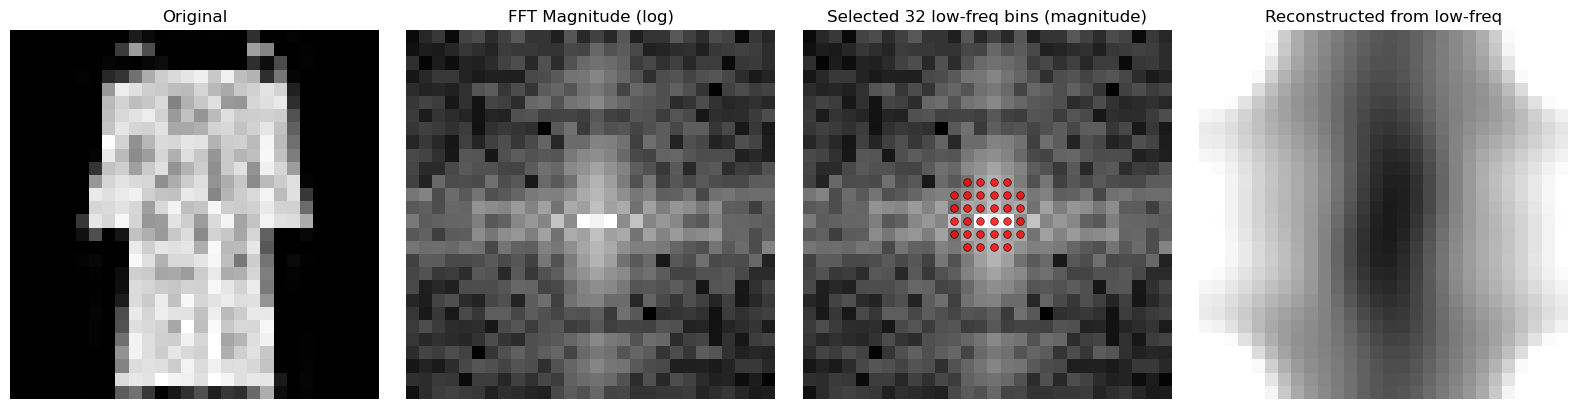


Pattern: Magnitude + High-freq


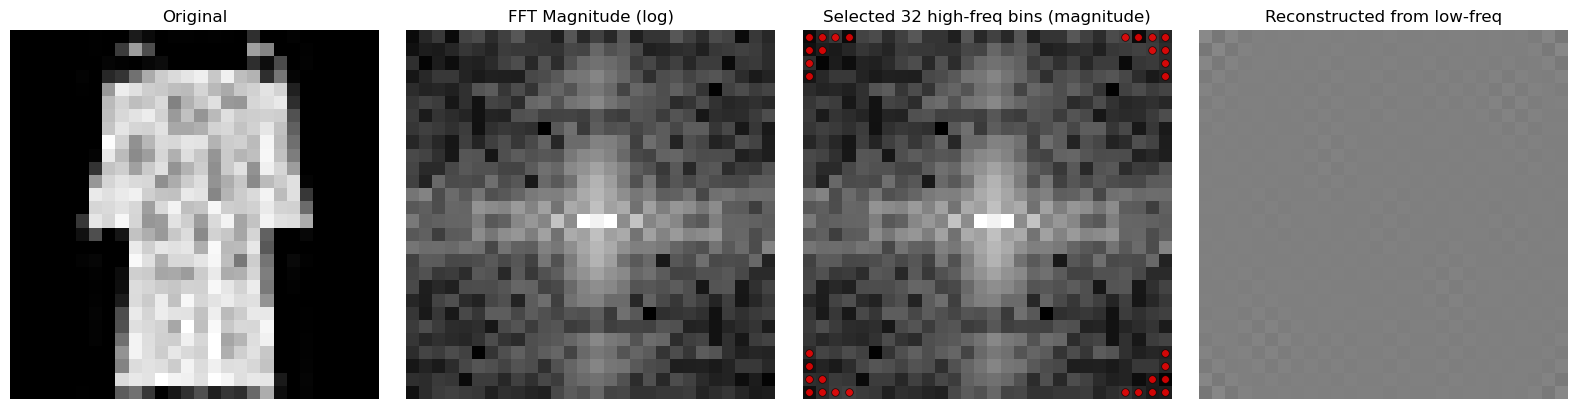


Pattern: Phase + Low-freq


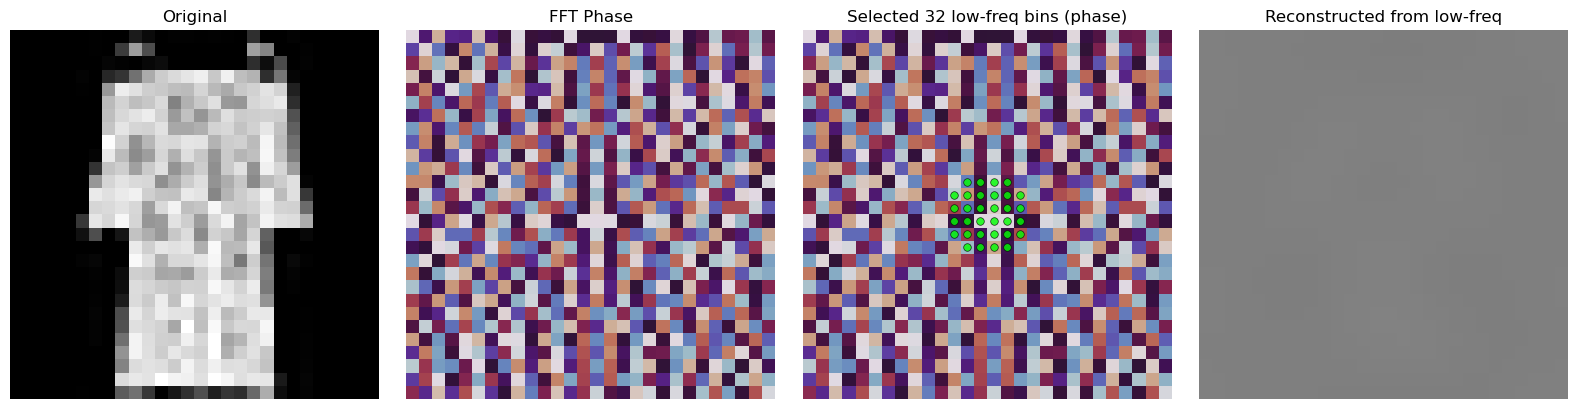


Pattern: Phase + High-freq


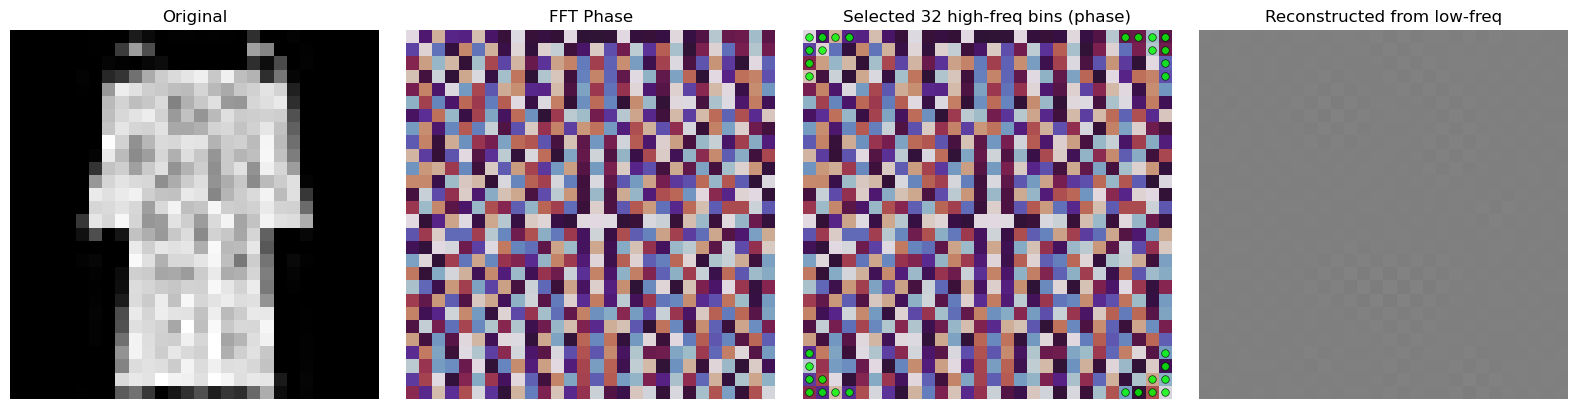

In [21]:
# 4パターンの可視化
def visualize_all_patterns():
    """
    4パターン全て (magnitude/phase × low/high) の可視化を実行
    """
    print("Loading Fashion-MNIST test data for visualization...")
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    
    root = os.path.join('..','..','dataloader', 'samples', 'Fmnist_data')
    fmnist_test = datasets.FashionMNIST(root=root, download=True, train=False, transform=transform)
    test_dataloader = DataLoader(fmnist_test, batch_size=100, shuffle=False)
    
    # 1バッチ取得
    x_batch, labels_batch = next(iter(test_dataloader))
    x_batch = x_batch.view(x_batch.size(0), 1, 28, 28)
    
    # 可視化するサンプルインデックス
    sample_index = 33
    print(f"\nVisualizing sample index: {sample_index}, label: {labels_batch[sample_index].item()}")
    
    # 4パターンの設定
    patterns = [
        {'mode': 'magnitude', 'freq_select': 'low', 'title': 'Magnitude + Low-freq'},
        {'mode': 'magnitude', 'freq_select': 'high', 'title': 'Magnitude + High-freq'},
        {'mode': 'phase', 'freq_select': 'low', 'title': 'Phase + Low-freq'},
        {'mode': 'phase', 'freq_select': 'high', 'title': 'Phase + High-freq'},
    ]
    
    for pattern in patterns:
        mode = pattern['mode']
        freq_select = pattern['freq_select']
        title = pattern['title']
        
        print(f"\n{'='*60}")
        print(f"Pattern: {title}")
        print(f"{'='*60}")
        
        # FFTLowFreqSelectorの初期化
        extractor = FFTLowFreqSelector(out_dim=32, mode=mode, freq_select=freq_select, log_magnitude=True)
    
        
        # 可視化を実行
        extractor.plot_example(x_batch, sample_index=sample_index, annotate=False, savepath=None)

# 実行
visualize_all_patterns()